In [1]:
! pip install pytorch_lightning

     |████████████████████████████████| 584 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 136 kB 38.3 MB/s 
     |████████████████████████████████| 409 kB 30.6 MB/s 
     |████████████████████████████████| 1.1 MB 29.4 MB/s 
     |████████████████████████████████| 271 kB 42.4 MB/s 
     |████████████████████████████████| 144 kB 56.5 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import numpy as np
from collections import defaultdict
import functools
import pandas as pd
import pickle

# Анализ распределения градиентов в зависимости он настроек архитектуры сети

В данном ноутбуке изучена зависимость распределений градиентов по слоям нейронной сети в зависимости от ее конфигурации.


## Архитектура

В качестве базовой архитектуры был выбран ResNet18.

Архитектура ResNet18:

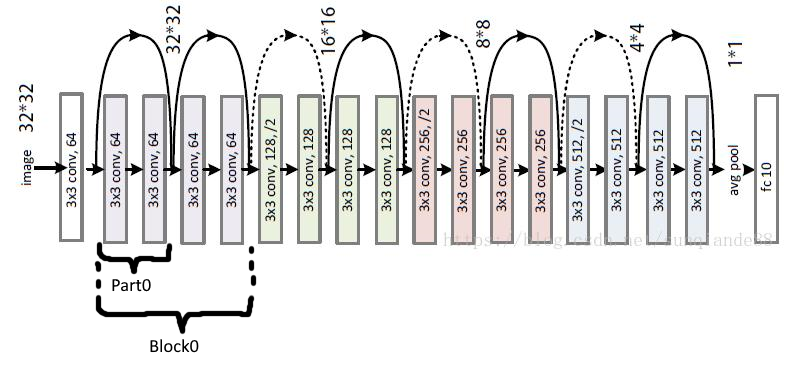

Выделим в сети две логические части: 
- **Часть** - две последовательные свертки 
- **Блок** - несколько последовательных частей (в блоке минимум одна часть)

В качестве настроек были выбраны следующие параметры:
- **Ширина** (`width`) - количество фильтров в каждом слое. Дальше мы под шириной мы будем подразумевать ширину первого блока (`block`). Ширина остальных блоков будет увеличиваться аналогично ResNet18.
- **Глубина** (`depth`) - количество частей (`part`) в блоке (`block`). Во всех блоках одинаковое количество частей.
- **BatchNorm** (`bn`) - использование или нет слоя BatchNorm перед активациями на всем протяжении сети.
- **DropOut** (`do`) - использование или нет слоя DropOut c вероятностью p (`do_p`) перед активациями и после возможного BatchNorm на всем протяжении сети.
- **Skip Connections** (`skip`) - использование или нет Skip Connections, как в оригинальной архитектуре ResNet18.
- **Инициализация** ('init') - разные начальные инициализации весов сети
- **Оптимизаторы** (`optim`) - разные оптимизаторы

### Код

Ниже приведен код модели на `Pytorch Lightning`:

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self,  in_chnls, use_bn, use_do, do_prob, use_skip, part_num, stride_first=2):
        super().__init__()
        out_chnls = 2 * in_chnls if stride_first == 2 else in_chnls
        self.part_num = part_num
        self.use_skip = use_skip

        for p in range(part_num):
            attr = "part" + str(p)
            self.__setattr__(attr, nn.Sequential())


            self.__getattr__(attr).add_module("conv0", 
                                              nn.Conv2d(
                                                  in_channels=in_chnls if p==0 else out_chnls,
                                                  out_channels=out_chnls,
                                                  kernel_size=3,
                                                  stride=stride_first if p == 0 else 1,
                                                  padding=1))
            if use_bn:
                self.__getattr__(attr).add_module("bn0", nn.BatchNorm2d(out_chnls))
            if use_do:
                self.__getattr__(attr).add_module("do0", nn.Dropout(p=do_prob))
            self.__getattr__(attr).add_module("relu0", nn.ReLU())

            self.__getattr__(attr).add_module("conv1", nn.Conv2d(out_chnls, out_chnls, 3, 1, 1))
            if use_bn:
                self.__getattr__(attr).add_module("bn1", nn.BatchNorm2d(out_chnls))
            if use_do:
                self.__getattr__(attr).add_module("do1", nn.Dropout(p=do_prob))
            
            self.__setattr__("part"+str(p)+"_lastrelu", nn.ReLU())
        
        if use_skip:
            for p in range(part_num): 
                attr = "skip" + str(p)
                if p == 0 and stride_first == 2:
                    self.__setattr__(attr, nn.Sequential(
                                                nn.Conv2d(in_chnls, out_chnls, 1, stride_first, bias=False),
                                                nn.BatchNorm2d(out_chnls)))
                else:
                    self.__setattr__(attr, nn.Sequential())

    def forward(self, x):
        for p in range(self.part_num): 
            out = self.__getattr__("part"+str(p))(x)
            if self.use_skip:
                out += self.__getattr__("skip"+str(p))(x)
            x = self.__getattr__("part"+str(p)+"_lastrelu")(out)

        return x


class CustomResNet18(pl.LightningModule):
    def __init__(self, conf, in_chnls=3, num_classes=10, lr=1e-2):
        super().__init__()
        self.conf = conf
        self.lr = lr
        self.bins = np.linspace(-10, 10, 200001)
        self.binsdict = defaultdict(lambda: np.zeros(200000, dtype=np.float64))
        self.curves = defaultdict(list)

        self.in_conv = nn.Conv2d(in_chnls, conf["width"], kernel_size=1, stride=1)
        self.block0 = ResidualBlock(conf["width"], conf["bn"], conf["do"], conf["do_p"], conf["use_skip"], conf["depth"], 1)
        self.block1 = ResidualBlock(conf["width"], conf["bn"], conf["do"], conf["do_p"], conf["use_skip"], conf["depth"], 2)
        self.block2 = ResidualBlock(2*conf["width"], conf["bn"], conf["do"], conf["do_p"], conf["use_skip"], conf["depth"], 2)
        self.block3 = ResidualBlock(4*conf["width"], conf["bn"], conf["do"], conf["do_p"], conf["use_skip"], conf["depth"], 2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(8*conf["width"], num_classes)
    
    def forward(self, x):
        out = self.in_conv(x)
        for i in range(4):
            out = self.__getattr__("block"+str(i))(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out
    
    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torch.mean((torch.argmax(y_hat, dim=-1) == y).float())

        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics, prog_bar=True)

        return metrics

    def configure_optimizers(self):
        optimizer = None
        if self.conf["optim"] == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.conf["optim"] == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        elif self.conf["optim"] == "nadam":
            optimizer = torch.optim.NAdam(self.parameters(), lr=self.lr)
        elif self.conf["optim"] == "adamw":
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)

        
        return optimizer
    
    def on_after_backward(self):
        for i in range(4):
            attr_list = ['block'+str(i), 'part0', 'conv1']
            layer = functools.reduce(lambda x, y: getattr(x, y), attr_list, self)
            curr_grad = layer.weight.grad.cpu().flatten().numpy()
            self.binsdict["_".join(attr_list)] += np.histogram(curr_grad, self.bins)[0]
        

### Датасет 

В качестве датасета мы использовали CIFAR-10. Ниже представлены примеры картинок:

In [8]:
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [40_000, 10_000])

dataset.__len__()

Files already downloaded and verified


50000

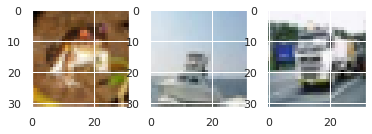

In [9]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(train.dataset.data[0])
ax[1].imshow(train.dataset.data[100])
ax[2].imshow(train.dataset.data[1000])

In [10]:
train_dataloader = DataLoader(train, batch_size=128, num_workers=2)
test_dataloader = DataLoader(val, batch_size=128, num_workers=2)

##Эксперименты

### Ширина

В данной части мы изучим влияние на градиенты сети **ширины** сети.

In [ ]:
dict_width = {}
main_par = ["width"]
for curr_width in [8, 16, 32, 64, 128]:
    conf = {"width": curr_width, "bn": True, "do": False, "do_p": 0.0, "use_skip": False, "depth": 2, "optim": "adam"}

    model = CustomResNet18(conf)
    trainer = pl.Trainer(max_epochs=10, accelerator="gpu", gpus=1)
    trainer.fit(model, train_dataloader)

    val = trainer.validate(model, dataloaders=test_dataloader)[0]["val_acc"]
    trn = trainer.validate(model, dataloaders=train_dataloader)[0]["val_acc"]

    sett = [f"$\\bf{{{k}={v}}}$" if k in main_par else f"{k}={v}" for k, v in conf.items()]
    sett += [f"trn_acc={trn:.3f}", f"val_acc={val:.3f}"]
    name = "; ".join(sett)

    dict_width[name] = dict(model.binsdict)

with open('dict_width.pickle', 'wb') as handle:
    pickle.dump(dict_width, handle)

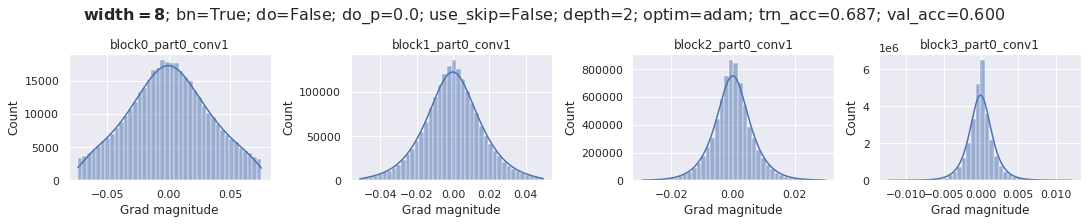

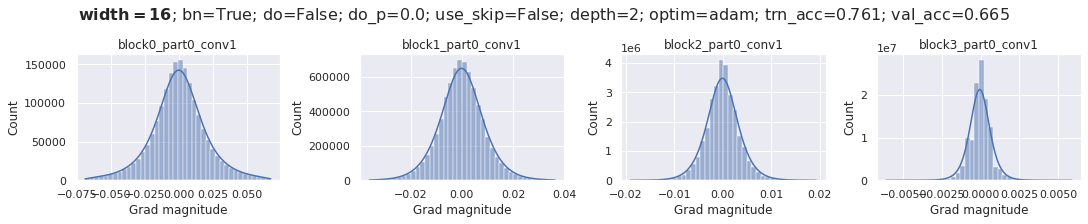

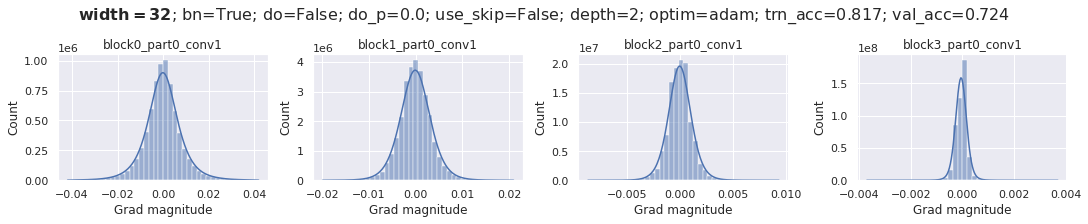

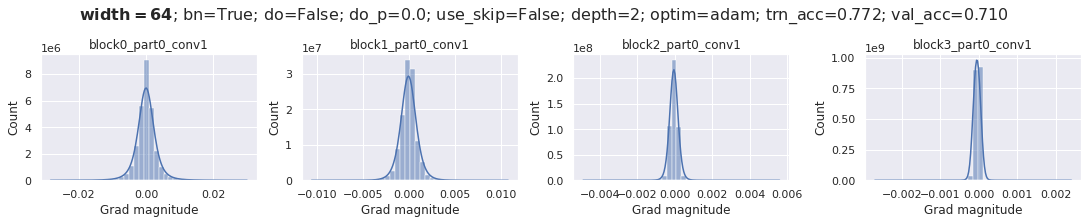

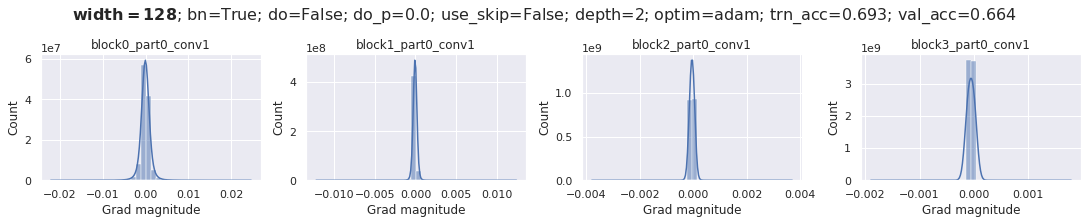

In [20]:
for name, curr_bins in dict_width.items():
    fig, ax = plt.subplots(1, len(curr_bins), figsize=(15, 3), constrained_layout=True)
    fig.suptitle(name, fontsize=16)
    for i, k_v in enumerate(curr_bins.items()):
        k, v = k_v
        thresh = 100
        first = np.argmax(v>thresh)
        last = v.shape[0] - np.argmax(v[::-1]>thresh) - 1
        bins = np.linspace(-10, 10, 200001)
        
        sns.histplot(x=bins[:-1][first:last], weights=v[first:last], bins=40, kde=True, ax=ax[i])
        ax[i].set_title(k)
        ax[i].set_xlabel("Grad magnitude")
    plt.show()

### Глубина

Скоро...

### BatchNorm и DropOut

В данной части мы изучим влияние на градиенты сети **BatchNorm** и DropOut.

In [ ]:
dict_bn_do = {}
main_par = ["bn", "do", "do_p"]
grid = [[False, False, 0.0], [True, False, 0.0],
        [False, True, 0.5], [True, True, 0.5], [True, True, 0.25]]

for curr_bn, curr_do, curr_do_p in grid:
    conf = {"width": 32, "bn": curr_bn, "do": curr_do, "do_p": curr_do_p, "use_skip": False, "depth": 2, "optim": "adam"}

    model = CustomResNet18(conf)
    trainer = pl.Trainer(max_epochs=10, accelerator="gpu")
    trainer.fit(model, train_dataloader)

    val = trainer.validate(model, dataloaders=test_dataloader)[0]["val_acc"]
    trn = trainer.validate(model, dataloaders=train_dataloader)[0]["val_acc"]

    sett = [f"$\\bf{{{k}={v}}}$" if k in main_par else f"{k}={v}" for k, v in conf.items()]
    sett += [f"trn_acc={trn:.3f}", f"val_acc={val:.3f}"]
    name = "; ".join(sett)

    dict_bn_do[name] = dict(model.binsdict)
    
with open('dict_bn_do.pickle', 'wb') as handle:
    pickle.dump(dict_bn_do, handle)

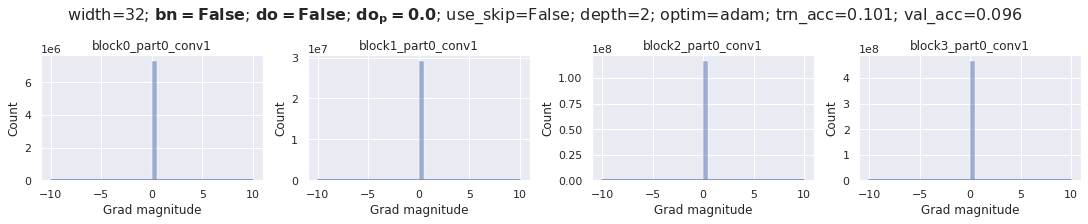

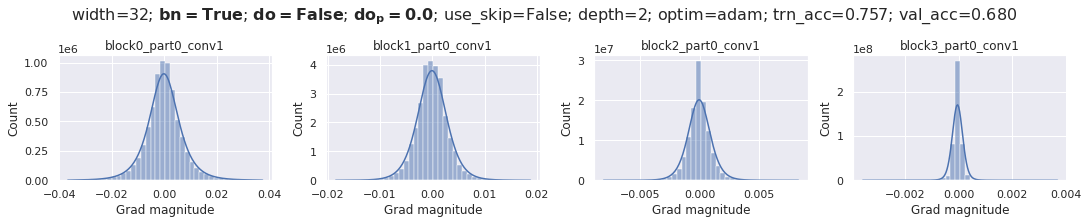

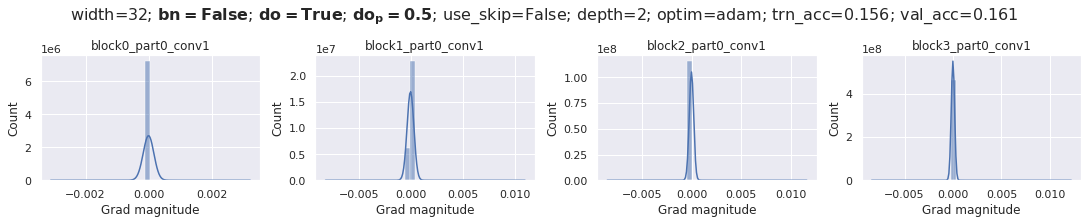

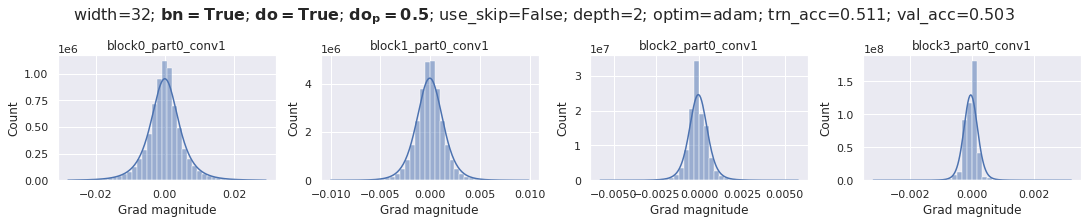

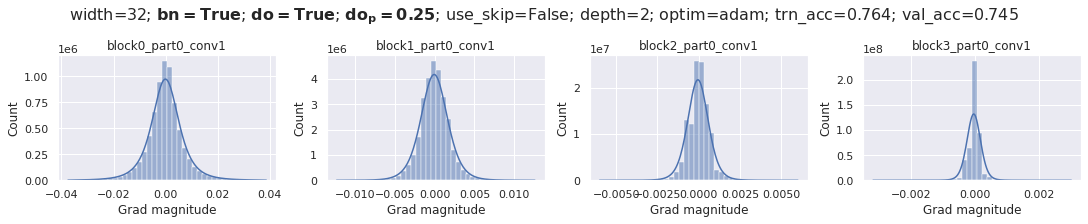

In [36]:
for j, kk_vv in enumerate(dict_bn_do.items()):
    name, curr_bins = kk_vv
    fig, ax = plt.subplots(1, len(curr_bins), figsize=(15, 3), constrained_layout=True)
    fig.suptitle(name, fontsize=16)
    for i, k_v in enumerate(curr_bins.items()):
        k, v = k_v
        thresh = -1 if j==0 else 100
        first = np.argmax(v>thresh)
        last = v.shape[0] - np.argmax(v[::-1]>thresh) - 1
        bins = np.linspace(-10, 10, 200001)

        sns.histplot(x=bins[:-1][first:last], weights=v[first:last], bins=40, kde=True, ax=ax[i])
        ax[i].set_title(k)
        ax[i].set_xlabel("Grad magnitude")
    plt.show()

## Skip Connections

В данной части мы изучим влияние на градиенты сети **Skip Connections**. 

In [ ]:
dict_skip = {}
main_par = ["use_skip", "bn"]
grid = [[False, False], [False, True], [True, False], [True, True]]

for curr_bn, curr_skip in grid:
    conf = {"width": 32, "bn": curr_bn, "do": False, "do_p": 0.0, "use_skip": curr_skip, "depth": 2, "optim": "adam"}

    model = CustomResNet18(conf)
    trainer = pl.Trainer(max_epochs=10, accelerator="gpu", gpus=1)
    trainer.fit(model, train_dataloader)

    val = trainer.validate(model, dataloaders=test_dataloader)[0]["val_acc"]
    trn = trainer.validate(model, dataloaders=train_dataloader)[0]["val_acc"]

    sett = [f"$\\bf{{{k}={v}}}$" if k in main_par else f"{k}={v}" for k, v in conf.items()]
    sett += [f"trn_acc={trn:.3f}", f"val_acc={val:.3f}"]
    name = "; ".join(sett)

    dict_skip[name] = dict(model.binsdict)

with open('dict_skip.pickle', 'wb') as handle:
    pickle.dump(dict_skip, handle)

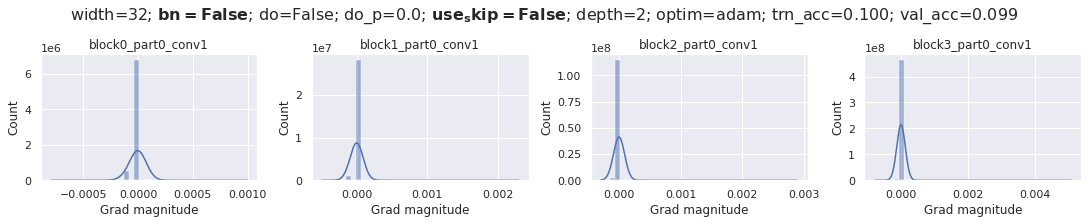

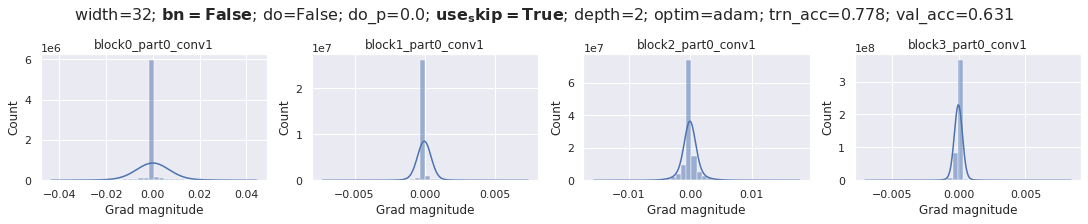

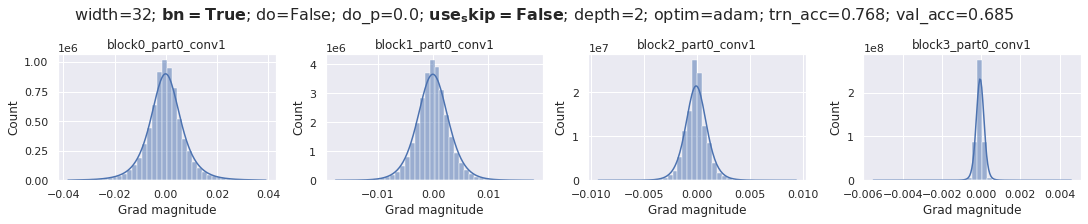

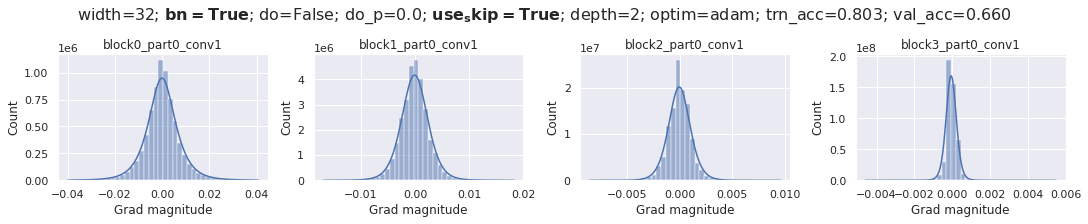

In [38]:
for name, curr_bins in dict_skip.items():
    fig, ax = plt.subplots(1, len(curr_bins), figsize=(15, 3), constrained_layout=True)
    fig.suptitle(name, fontsize=16)
    for i, k_v in enumerate(curr_bins.items()):
        k, v = k_v
        thresh = 100
        first = np.argmax(v>thresh)
        last = v.shape[0] - np.argmax(v[::-1]>thresh) - 1
        bins = np.linspace(-10, 10, 200001)
        
        sns.histplot(x=bins[:-1][first:last], weights=v[first:last], bins=40, kde=True, ax=ax[i])
        ax[i].set_title(k)
        ax[i].set_xlabel("Grad magnitude")
    plt.show()

### Инициализация

Не успел....

### Оптимизаторы

В данной части мы изучим влияние на градиенты сети **отпимизаторов**.

In [ ]:
dict_optim = {}
main_par = ["optim"]
grid = ["sgd", "adam", "nadam", "adamw"]

for curr_optim in grid:
    conf = {"width": 32, "bn": True, "do": False, "do_p": 0.0, "use_skip": False, "depth": 2, "optim": curr_optim}

    model = CustomResNet18(conf)
    trainer = pl.Trainer(max_epochs=10, accelerator="gpu", gpus=1)
    trainer.fit(model, train_dataloader)

    val = trainer.validate(model, dataloaders=test_dataloader)[0]["val_acc"]
    trn = trainer.validate(model, dataloaders=train_dataloader)[0]["val_acc"]

    sett = [f"$\\bf{{{k}={v}}}$" if k in main_par else f"{k}={v}" for k, v in conf.items()]
    sett += [f"trn_acc={trn:.3f}", f"val_acc={val:.3f}"]
    name = "; ".join(sett)

    dict_optim[name] = dict(model.binsdict)

with open('dict_optim.pickle', 'wb') as handle:
    pickle.dump(dict_optim, handle)

In [37]:
# with open("/content/drive/MyDrive/Datasets/dl1/dict_skip.pickle", "rb") as f:
#     dict_skip = pickle.load(f)